# Second Project

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from code import data_preparation as dp
from code import visualizations as viz
import matplotlib.pyplot as plt
%matplotlib inline

## Initial Data Exploration

We will be using data from _ to create our model. To begin, let's look at some of the features of the raw data.

In [2]:
data = pd.read_csv('data/kc_house_data.csv')

In [3]:
data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,...,7 Average,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,7 Average,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,6 Low Average,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,7 Average,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,8 Good,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


As we can see by looking at the info, a large number of columns are stored as objects rather than floats or ints and must be converted for analysis.

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  object 
 9   view           21534 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

Looking at the distribution of the numerical data, we can note both the presence of some extreme outliers and a clear rightward skew in many of the distributions.

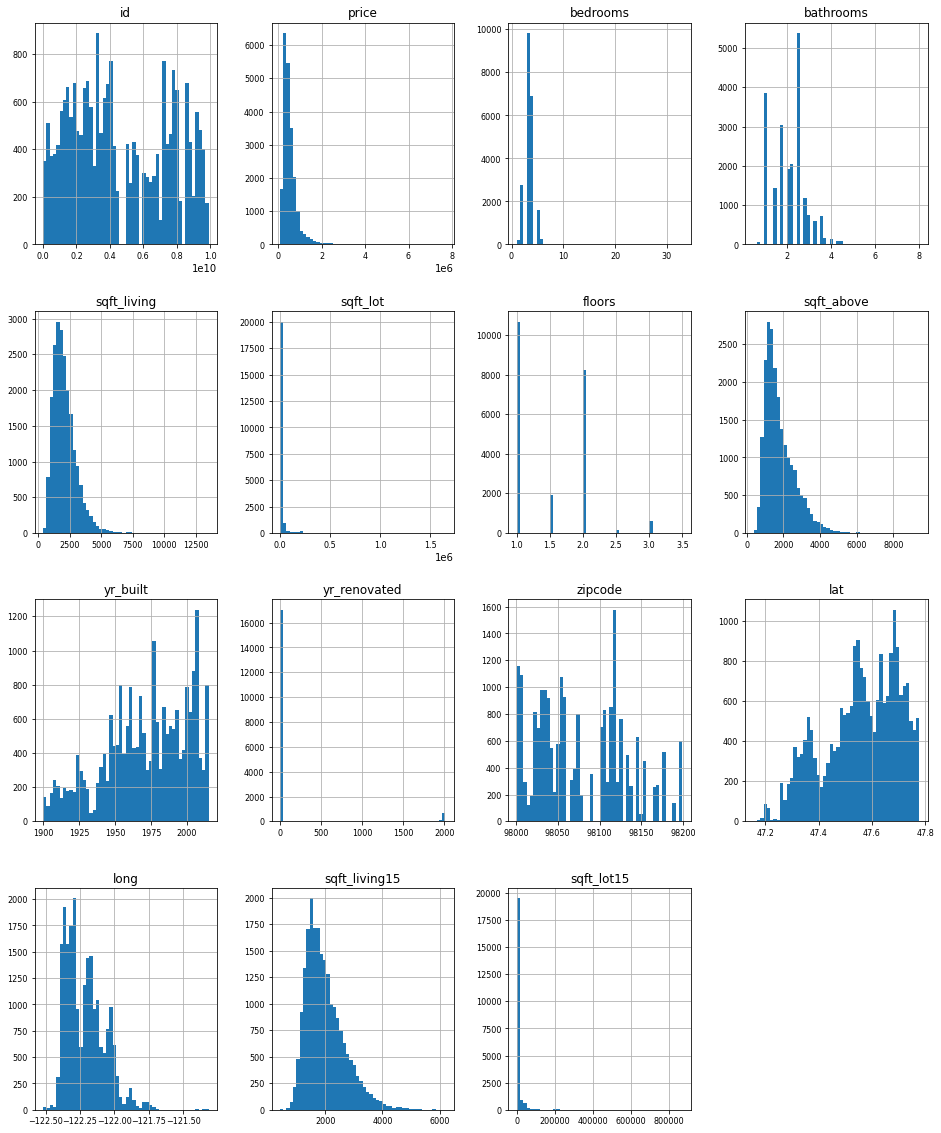

In [5]:
data.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);

For example there is a home with 33 bedrooms and a huge lot of over 1.5 million sqft

In [6]:
data.bedrooms.value_counts()

3     9824
4     6882
2     2760
5     1601
6      272
1      196
7       38
8       13
9        6
10       3
11       1
33       1
Name: bedrooms, dtype: int64

In [7]:
data.sqft_lot.max()

1651359

Looking at the object columns we can see there are many zero values in the sqft_basement column, many None values in the view column and many NO values in the waterfront column.

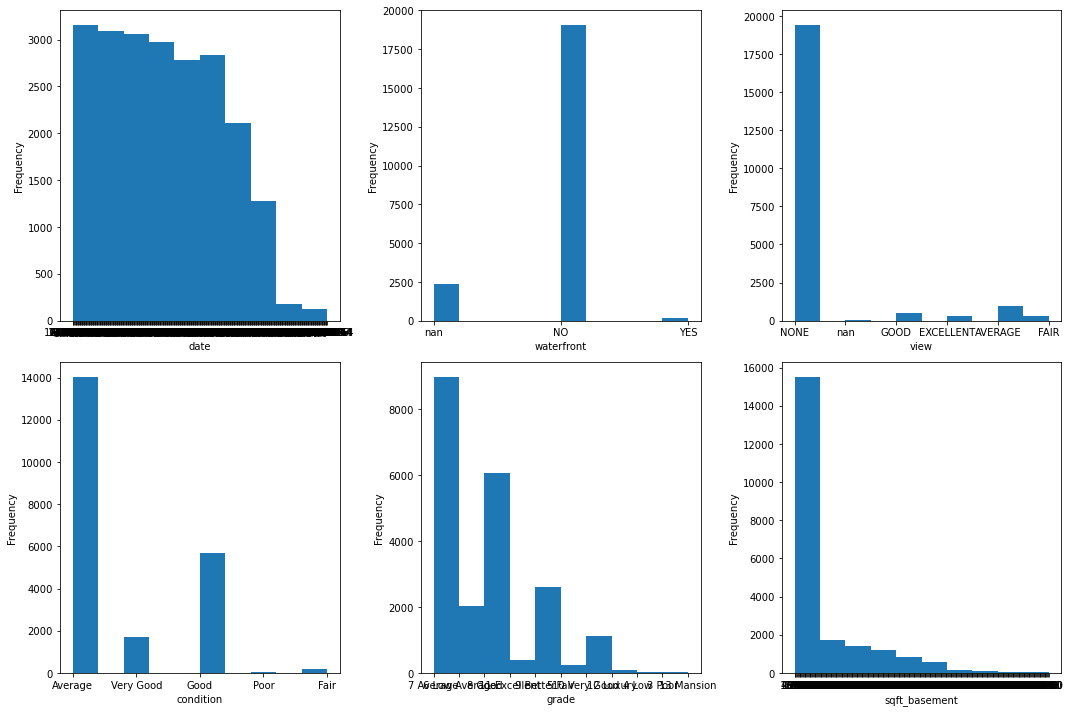

In [8]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(15, 10))
fig.set_tight_layout(True)

for index, col in enumerate(data.select_dtypes(object).columns):
    ax = axes[index//3][index%3]
    ax.hist(data[col], bins = 10)
    ax.set_xlabel(col)
    ax.set_ylabel("Frequency")

Examining the correlations between the columns in the unprocessed data, we have some indication that sqft_living, sqft_above, sqft_living15 and bathrooms all have a correlation of over 0.5 with price. 

We can also see a lot of correlation between sqft_living15, which is the size of neighboring homes to the one sold and many things related to the sold homes size. Quite likely homes in a neighborhood tend to be of similar size. 

Lastly, there is obviously a lot of correlation between floors, bedroom, bathrooms and between different measures of the sqft of homes. This will likely produce a lot of collinearity in the model.

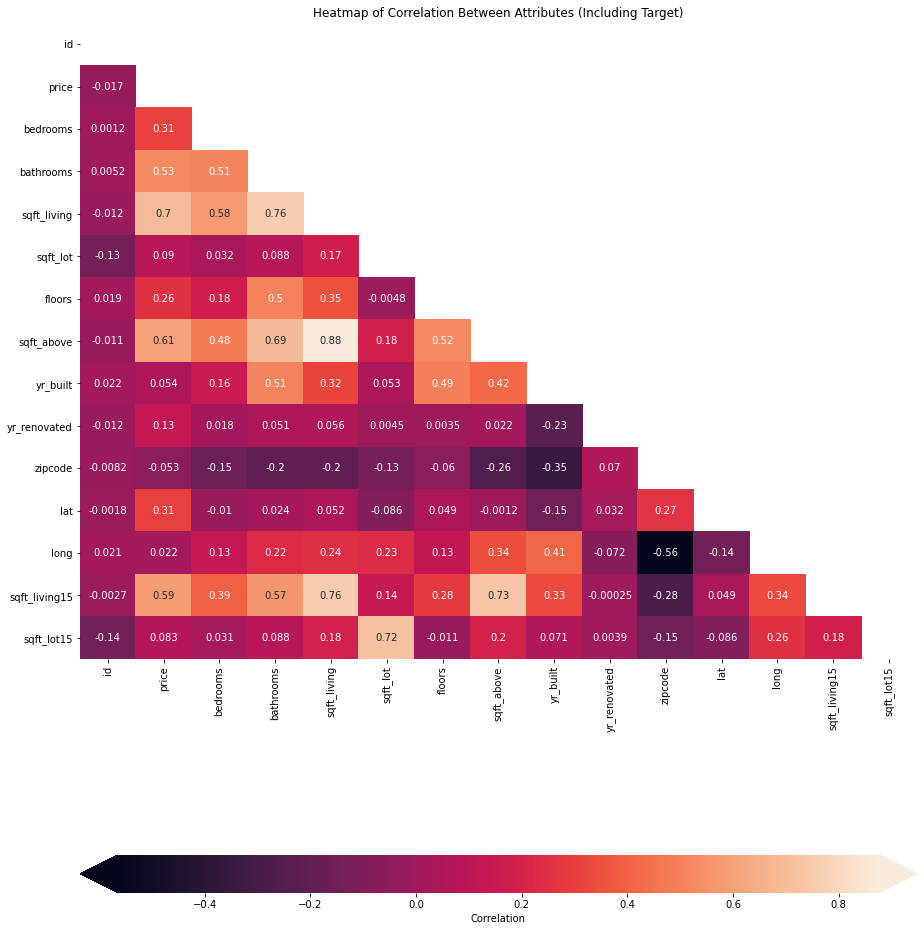

In [9]:
viz.create_heatmap(data, size =(15,18))

We can also examine the data for duplicate rows by seeing if there are common id numbers. There are 176 rows with duplicate id numbers.

In [10]:
data.id.value_counts()

795000620     3
1825069031    2
2019200220    2
7129304540    2
1781500435    2
             ..
7812801125    1
4364700875    1
3021059276    1
880000205     1
1777500160    1
Name: id, Length: 21420, dtype: int64

In [11]:
sum(data.id.value_counts()>1)

176

But, investigating further, these seem to be the same homes sold two or three times in the 2014 to 2015 timeframe that the data covers. 

In [12]:
flipped = data[data.duplicated('id', keep=False) == True]
flipped.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
93,6021501535,7/25/2014,430000.0,3,1.50,1580,5000,1.0,NO,NONE,...,8 Good,1290,290.0,1939,0.0,98117,47.6870,-122.386,1570,4500
94,6021501535,12/23/2014,700000.0,3,1.50,1580,5000,1.0,NO,NONE,...,8 Good,1290,290.0,1939,0.0,98117,47.6870,-122.386,1570,4500
313,4139480200,6/18/2014,1380000.0,4,3.25,4290,12103,1.0,NO,GOOD,...,11 Excellent,2690,1600.0,1997,0.0,98006,47.5503,-122.102,3860,11244
314,4139480200,12/9/2014,1400000.0,4,3.25,4290,12103,1.0,NO,GOOD,...,11 Excellent,2690,1600.0,1997,0.0,98006,47.5503,-122.102,3860,11244
324,7520000520,9/5/2014,232000.0,2,1.00,1240,12092,1.0,NaN,NONE,...,6 Low Average,960,280.0,1922,1984.0,98146,47.4957,-122.352,1820,7460


It is perhaps worth checking to see if any of this flipped homes were also renovated during that time, which might be relevant to an analysis of how home renovations affected home prices, but looking at the homes sold multiple times, there are none that were renovated even as recently as 2000, with the most recent being done in 1990.

In [13]:
flipped[flipped['yr_renovated']>1980]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
324,7520000520,9/5/2014,232000.0,2,1.00,1240,12092,1.0,NaN,NONE,...,6 Low Average,960,280.0,1922,1984.0,98146,47.4957,-122.352,1820,7460
325,7520000520,3/11/2015,240500.0,2,1.00,1240,12092,1.0,NO,NONE,...,6 Low Average,960,280.0,1922,1984.0,98146,47.4957,-122.352,1820,7460
717,8820903380,7/28/2014,452000.0,6,2.25,2660,13579,2.0,NO,NONE,...,7 Average,2660,0.0,1937,1990.0,98125,47.7142,-122.286,1120,8242
718,8820903380,1/2/2015,730000.0,6,2.25,2660,13579,2.0,NO,NONE,...,7 Average,2660,0.0,1937,1990.0,98125,47.7142,-122.286,1120,8242


## Cleaning the Data

Since we are not doing time analysis we will delete the date column. The id number cannot be used in regression and will be removed. We will use zipcodes for location information and so will remove lat/long info as well.

In [14]:
irrelevant = ['id', 'date', 'lat', 'long']
relevant = data.drop(columns=irrelevant)

In [15]:
relevant.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,sqft_living15,sqft_lot15
0,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,Average,7 Average,1180,0.0,1955,0.0,98178,1340,5650
1,538000.0,3,2.25,2570,7242,2.0,NO,NONE,Average,7 Average,2170,400.0,1951,1991.0,98125,1690,7639
2,180000.0,2,1.00,770,10000,1.0,NO,NONE,Average,6 Low Average,770,0.0,1933,NaN,98028,2720,8062
3,604000.0,4,3.00,1960,5000,1.0,NO,NONE,Very Good,7 Average,1050,910.0,1965,0.0,98136,1360,5000
4,510000.0,3,2.00,1680,8080,1.0,NO,NONE,Average,8 Good,1680,0.0,1987,0.0,98074,1800,7503


### Dealing with Missing Values

#### *Dealing with Renovation Year Data*

We can see there are 3842 missing values about what year renovations we done, and a large number of zero values as well.

In [16]:
relevant['yr_renovated'].isna().sum()

3842

In [17]:
relevant['yr_renovated'].value_counts()

0.0       17011
2014.0       73
2003.0       31
2013.0       31
2007.0       30
          ...  
1946.0        1
1959.0        1
1971.0        1
1951.0        1
1954.0        1
Name: yr_renovated, Length: 70, dtype: int64

We will add a column indicating which values are missing and assume that NaN values are 0 values and represent no renovation. We will also bin the renovations into three categories: "not_renovated", "new_renovations", "old_renovations". We will define new renovations as ones that have been done in the past 10 years. We will then one-hot encode it so it can be used in a regression.

In [18]:
relevant['yr_ren_miss'] = dp.missing_indicator(relevant, 'yr_renovated')
relevant['yr_renovated'] = dp.impute_values(relevant, 'yr_renovated', type='median')
relevant['yr_renovated'].isna().sum()

0

In [19]:
def find_old_new(x, threshold=10):
    if x > (2020-threshold):
        return "new_ren"
    elif x == 0:
        return "not_ren"
    else:
        return "old_ren"

In [20]:
relevant['yr_renovated'] = relevant['yr_renovated'].apply(find_old_new)
cats_yr_ren, encode_yr_ren = dp.one_hot_encode(relevant, 'yr_renovated')
relevant[cats_yr_ren] = encode_yr_ren 

In [21]:
#One column dropped to avoid dummy variable trap
clean = relevant.drop(columns=['yr_renovated', 'not_ren'])
clean.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'zipcode', 'sqft_living15', 'sqft_lot15',
       'yr_ren_miss', 'new_ren', 'old_ren'],
      dtype='object')

#### *Dealing with Waterfront Data*

There are 2376 null values in the waterfront data and most of the values are 'NO'.

In [22]:
clean['waterfront'].isna().sum()

2376

In [23]:
clean['waterfront'].value_counts()

NO     19075
YES      146
Name: waterfront, dtype: int64

For the waterfront data, we will also add a missing column and will assume that the missing values are properties that lack a waterfront. We will also binary encode this column.

In [24]:
clean['waterfront_miss'] = dp.missing_indicator(clean, 'waterfront')
clean = clean.replace({'NO': 0, 'YES': 1})
clean['waterfront'] = dp.impute_values(clean, 'waterfront', type='median')
clean.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'zipcode', 'sqft_living15', 'sqft_lot15',
       'yr_ren_miss', 'new_ren', 'old_ren', 'waterfront_miss'],
      dtype='object')

In [25]:
clean['waterfront'].isna().sum()

0

#### *Dealing with View Data*

There are 63 missing view data entries and most of the remaining values are 'NONE'.

In [26]:
clean['view'].isna().sum()

63

In [27]:
clean['view'].value_counts()

NONE         19422
AVERAGE        957
GOOD           508
FAIR           330
EXCELLENT      317
Name: view, dtype: int64

Given how few homes are actually rated, we will drop the view column from out analysis.

In [28]:
clean = clean.drop(columns=['view'])
clean.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'condition', 'grade', 'sqft_above', 'sqft_basement',
       'yr_built', 'zipcode', 'sqft_living15', 'sqft_lot15', 'yr_ren_miss',
       'new_ren', 'old_ren', 'waterfront_miss'],
      dtype='object')

We have now dealt with the missing data.

In [29]:
clean.isna().sum()

price              0
bedrooms           0
bathrooms          0
sqft_living        0
sqft_lot           0
floors             0
waterfront         0
condition          0
grade              0
sqft_above         0
sqft_basement      0
yr_built           0
zipcode            0
sqft_living15      0
sqft_lot15         0
yr_ren_miss        0
new_ren            0
old_ren            0
waterfront_miss    0
dtype: int64

### Dealing with Non-Numerical Data

In order to make a model we need to transform categorical data into numerical data. As we can see the condition, grade, and sqft_basement columns are objects, and will have to be transformed.

In [30]:
clean.select_dtypes(object)

,condition,grade,sqft_basement
0,Average,7 Average,0.0
1,Average,7 Average,400.0
2,Average,6 Low Average,0.0
3,Very Good,7 Average,910.0
4,Average,8 Good,0.0
...,...,...,...
21592,Average,8 Good,0.0
21593,Average,8 Good,0.0
21594,Average,7 Average,0.0
21595,Average,8 Good,0.0


#### *Dealing with Grade Column*

As we can see the grade column does include numerical ratings along with a short description of what they mean. 

In [31]:
clean['grade'].value_counts()

7 Average        8974
8 Good           6065
9 Better         2615
6 Low Average    2038
10 Very Good     1134
11 Excellent      399
5 Fair            242
12 Luxury          89
4 Low              27
13 Mansion         13
3 Poor              1
Name: grade, dtype: int64

However since we can't assume that a 10 is twice as good as a 5, we will one-hot encoded the grades, as well as drop homes in the the mansion and poor categories since they are outlier unlikely to be relevant to the median homeseller.

In [32]:
clean['grade'] = clean['grade'].map(lambda x: x.split()[0])

In [33]:
clean = clean.drop(clean[clean.grade == '13'].index)
clean = clean.drop(clean[clean.grade == '3'].index)
clean['grade'].value_counts()

7     8974
8     6065
9     2615
6     2038
10    1134
11     399
5      242
12      89
4       27
Name: grade, dtype: int64

In [34]:
cats_grade, encode_grade = dp.one_hot_encode(clean, 'grade', prefix='grade_')
clean[cats_grade] = encode_grade 

In [35]:
#One column dropped to avoid dummy variable trap
clean = clean.drop(columns=['grade', 'grade_4'])
clean.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'condition', 'sqft_above', 'sqft_basement', 'yr_built',
       'zipcode', 'sqft_living15', 'sqft_lot15', 'yr_ren_miss', 'new_ren',
       'old_ren', 'waterfront_miss', 'grade_10', 'grade_11', 'grade_12',
       'grade_5', 'grade_6', 'grade_7', 'grade_8', 'grade_9'],
      dtype='object')

#### *Dealing with Condition Column*

The condition column must also be encoded.

In [36]:
clean['condition'].value_counts()

Average      14009
Good          5675
Very Good     1700
Fair           170
Poor            29
Name: condition, dtype: int64

Like the grade column we will one-hot encode it.

In [37]:
cats_cond, encode_cond = dp.one_hot_encode(clean, 'condition', prefix='cond_')
clean[cats_cond]=encode_cond

In [38]:
#One column dropped to avoid dummy variable trap
clean = clean.drop(columns=['condition', 'cond_Poor'])
clean.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'sqft_above', 'sqft_basement', 'yr_built', 'zipcode',
       'sqft_living15', 'sqft_lot15', 'yr_ren_miss', 'new_ren', 'old_ren',
       'waterfront_miss', 'grade_10', 'grade_11', 'grade_12', 'grade_5',
       'grade_6', 'grade_7', 'grade_8', 'grade_9', 'cond_Average', 'cond_Fair',
       'cond_Good', 'cond_Very Good'],
      dtype='object')

#### *Dealing with Sqft Basement Column*

As we can see, there are many 0 values along with some hidden missing values that were input as '?'.

In [39]:
clean['sqft_basement'].value_counts()

0.0       12822
?           454
600.0       216
500.0       209
700.0       207
          ...  
652.0         1
2250.0        1
1024.0        1
915.0         1
2500.0        1
Name: sqft_basement, Length: 301, dtype: int64

To make the analysis simpler we will just bin homes by whether they have a basement and will assume that all the ? values are homes lacking basements.

In [40]:
clean['sqft_basement'].replace('?', np.nan, inplace=True)
clean['sqft_base_miss'] = dp.missing_indicator(clean, 'sqft_basement')
clean['sqft_basement'] = dp.impute_values(clean,'sqft_basement', type='median')
clean['sqft_basement'] = clean.sqft_basement.astype(int)

In [41]:
clean['sqft_basement'].value_counts()

0       13276
600       216
500       209
700       207
800       201
        ...  
602         1
506         1
266         1
276         1
1135        1
Name: sqft_basement, Length: 300, dtype: int64

In [42]:
def label_basement(x):
    if x > 0:
        return "has_basement"
    else:
        return "no_basement"

In [43]:
clean['sqft_basement'] = clean['sqft_basement'].apply(label_basement)
cats_basement, encode_basement = dp.one_hot_encode(clean, 'sqft_basement')
clean[cats_basement] = encode_basement

In [44]:
#One column dropped to avoid dummy variable trap
clean = clean.drop(columns=['sqft_basement', 'no_basement'])
clean.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'sqft_above', 'yr_built', 'zipcode', 'sqft_living15',
       'sqft_lot15', 'yr_ren_miss', 'new_ren', 'old_ren', 'waterfront_miss',
       'grade_10', 'grade_11', 'grade_12', 'grade_5', 'grade_6', 'grade_7',
       'grade_8', 'grade_9', 'cond_Average', 'cond_Fair', 'cond_Good',
       'cond_Very Good', 'sqft_base_miss', 'has_basement'],
      dtype='object')

Lastly we will convert the boolean values of the missings columns to int for the purpose of regression.

In [45]:
clean[["yr_ren_miss","sqft_base_miss","waterfront_miss"]] = clean[["yr_ren_miss","sqft_base_miss","waterfront_miss"]].astype(int)

In [46]:
clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21583 entries, 0 to 21596
Data columns (total 30 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   price            21583 non-null  float64
 1   bedrooms         21583 non-null  int64  
 2   bathrooms        21583 non-null  float64
 3   sqft_living      21583 non-null  int64  
 4   sqft_lot         21583 non-null  int64  
 5   floors           21583 non-null  float64
 6   waterfront       21583 non-null  float64
 7   sqft_above       21583 non-null  int64  
 8   yr_built         21583 non-null  int64  
 9   zipcode          21583 non-null  int64  
 10  sqft_living15    21583 non-null  int64  
 11  sqft_lot15       21583 non-null  int64  
 12  yr_ren_miss      21583 non-null  int32  
 13  new_ren          21583 non-null  float64
 14  old_ren          21583 non-null  float64
 15  waterfront_miss  21583 non-null  int32  
 16  grade_10         21583 non-null  float64
 17  grade_11    

All the obviously categorical data is in numerical form now but some categorical data is still there.

 ### Dealing with Year Built

The year built is something we could directly use in a regression if we wished, but for our purposes, the more relevant thing is how old the home is. We will add a calculated column for the age of the home and use that instead as a marker of home age.

In [47]:
clean['home_age'] = 2015 - clean['yr_built']
clean = clean.drop(columns=['yr_built'])

In [48]:
clean.home_age.value_counts()

1      559
9      453
10     450
11     432
12     420
      ... 
82      29
114     29
113     27
80      24
81      21
Name: home_age, Length: 116, dtype: int64

 ### Dealing with Locations

To deal with locations, we will bin the data by neighborhood, to do so we will use a csv file I created with each zipcode in King County labeled by neighborhood.

In [49]:
neighborhoods = pd.read_csv('data/king_county_neighborhoods.csv')
neighborhoods.head()

,Zipcode,Neighborhood
0,98010,Black Diamond
1,98038,Maple Valley
2,98070,Vashon Island
3,98023,Federal Way
4,98003,Federal Way


As we can see there are labels for all the zipcodes in the data set plus a few more in King County that had no home sales in the data.

In [50]:
set(clean.zipcode.unique()) - set(neighborhoods['Zipcode'])

set()

In [51]:
set(neighborhoods['Zipcode']) - set(clean.zipcode.unique())

{98047, 98051, 98057, 98101, 98104, 98121, 98134, 98158, 98195, 98224, 98288}

Using the info in the file we can convert the zipcodes into neighborhood labels and then one-hot encode them.

In [52]:
neighborhoods.set_index("Zipcode", inplace = True)
neighbor_dict = neighborhoods.to_dict()

In [53]:
clean['zipcode'] = clean['zipcode'].replace(neighbor_dict['Neighborhood'])

In [54]:
clean.zipcode.value_counts()

N Seattle         1600
Renton            1596
Ballard           1421
Bellevue          1404
West Seattle      1282
Kent              1201
Redmond           1175
Kirkland           976
SE Seattle         955
Auburn             911
NE Seattle         812
Burlen             811
Sammamish          800
Federal Way        779
Issaquah           733
Downtown           633
Queen Anne         609
Maple Valley       589
Capital Hill       371
Snoqualmie         308
Kenmore            283
Mercer Island      282
Des Moines         280
Woodinville        273
SE King County     232
North Bend         220
Bothell            195
Seatac             193
Duvail             190
Carnation          124
Vashon Island      117
Black Diamond      100
NE King County      80
Medina              48
Name: zipcode, dtype: int64

In [55]:
cats_zip, encode_zip = dp.one_hot_encode(clean, 'zipcode')
clean[cats_zip] = encode_zip

In [56]:
#One column dropped to avoid dummy variable trap
clean = clean.drop(columns=['zipcode', 'Auburn'])
clean.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'sqft_above', 'sqft_living15', 'sqft_lot15',
       'yr_ren_miss', 'new_ren', 'old_ren', 'waterfront_miss', 'grade_10',
       'grade_11', 'grade_12', 'grade_5', 'grade_6', 'grade_7', 'grade_8',
       'grade_9', 'cond_Average', 'cond_Fair', 'cond_Good', 'cond_Very Good',
       'sqft_base_miss', 'has_basement', 'home_age', 'Ballard', 'Bellevue',
       'Black Diamond', 'Bothell', 'Burlen', 'Capital Hill', 'Carnation',
       'Des Moines', 'Downtown', 'Duvail', 'Federal Way', 'Issaquah',
       'Kenmore', 'Kent', 'Kirkland', 'Maple Valley', 'Medina',
       'Mercer Island', 'N Seattle', 'NE King County', 'NE Seattle',
       'North Bend', 'Queen Anne', 'Redmond', 'Renton', 'SE King County',
       'SE Seattle', 'Sammamish', 'Seatac', 'Snoqualmie', 'Vashon Island',
       'West Seattle', 'Woodinville'],
      dtype='object')

The floor, bathroom, and bedroom data perhaps ought to be treated as categorical too, but for now we will proceed by treating these categories as label encoded. 

## Making a Base Model

To begin we will construct a basic model that just predicts how prices based on the most correlated non-location variable with home prices.

In [59]:
locations = ['Ballard', 'Bellevue', 'Black Diamond', 'Bothell', 'Burlen',
                 'Capital Hill', 'Carnation', 'Des Moines', 'Downtown', 'Duvail',
                 'Federal Way', 'Issaquah', 'Kenmore', 'Kent', 'Kirkland',
                 'Maple Valley', 'Medina', 'Mercer Island', 'N Seattle',
                 'NE King County', 'NE Seattle', 'North Bend', 'Queen Anne', 'Redmond',
                 'Renton', 'SE King County', 'SE Seattle', 'Sammamish', 'Seatac',
                 'Snoqualmie', 'Vashon Island', 'West Seattle', 'Woodinville']
non_location = clean.drop(columns = locations)

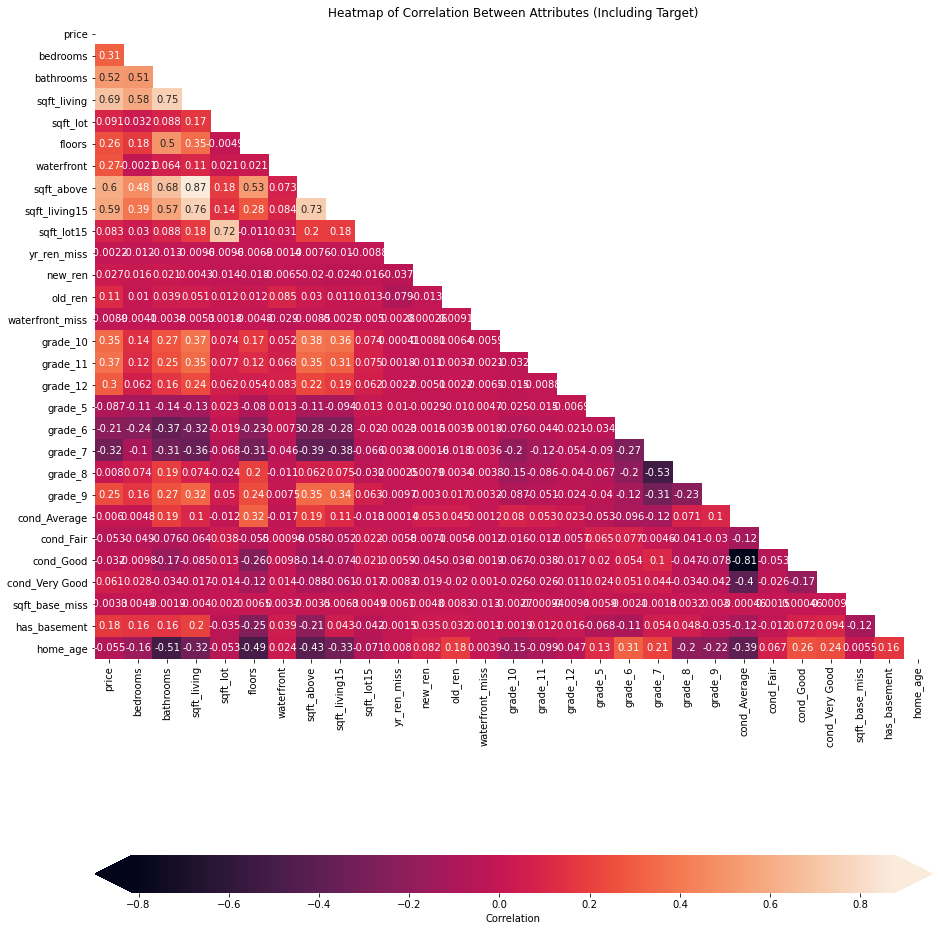

In [60]:
viz.create_heatmap(non_location, size =(15,18))

Sqft_living is the most correlated variable with home price, let's quickly visualize the correlation.

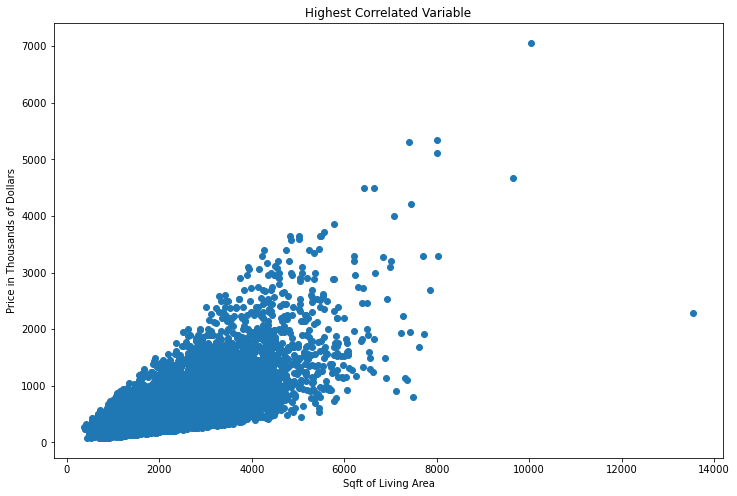

In [61]:
X_train_base = clean[['sqft_living']]
y_train_base = clean['price']
fig, ax = plt.subplots(figsize=(12,8))
plt.scatter(X_train_base, y_train_base/1000)
plt.xlabel('Sqft of Living Area')
plt.ylabel('Price in Thousands of Dollars')
plt.title('Highest Correlated Variable');

In our initial model we will only use 'sqft_living' the variable most correlated with our target variable price. 

In [62]:
baseline_model = LinearRegression()
base_val = dp.cross_val(baseline_model, X_train_base, y_train_base, splits=10, test_size=0.25, random_state=0)

Train score:      0.48295393411547033
Validation score: 0.4809902533078457


The squre footage of the living space only accounts for about 48% of the variance in our data, given the visualization of their relationship, we can see that the variance in price also increases with the living space, indicating the data is likely heteroskedastic, so a linear model on just this variable will be inefficient.

## Improving the Model

#### Adding More Variables

The first thing we can attempt to do to improve the model is add in more variables. Let's add them all in and see how the model performs.

In [63]:
X_train_all = clean.drop(columns='price')
y_train_all = clean['price']
all_model = LinearRegression()
all_val = dp.cross_val(all_model, X_train_all, y_train_all, splits=10, test_size=0.25, random_state=0)

Train score:      0.7902198595976243
Validation score: 0.7881135057811519


#### Improving Normality

As we can see, all the varibles explain about 79% of the variance in price in our data as it stands. One potential place that we could still be having issues is in the normality of the data. Let's look at a Q-Q plot to check.

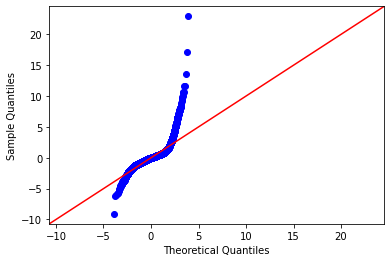

In [66]:
all_model.fit(X_train_all, y_train_all)
viz.normality_graph(all_model, X_train_all, y_train_all)

This plot indicates that our data is not very normal.

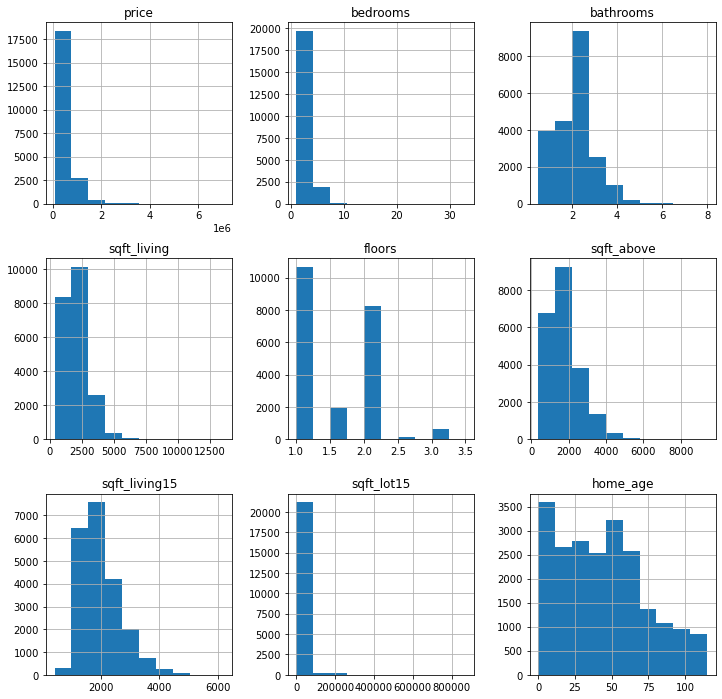

In [65]:
nonbool_columns = ['price','bedrooms','bathrooms','sqft_living','floors','sqft_above', 'sqft_living15', 'sqft_lot15', 'home_age']
clean[nonbool_columns].hist(figsize  = [12, 12]); 

We can also see that the non-boolean columns are all skewed with lots of data cluttered around zero. We can also see that the number in the scale are also very different, with some being in the single digits and others in the thousands. We will try to deal with both this issues by log normalizing the data that varies continuously.

In [67]:
cont_columns = ['price', 'sqft_living', 'sqft_above', 'sqft_living15', 'sqft_lot15', 'home_age']
continous_df = clean[cont_columns]
noncontinous_df = clean.drop(columns=cont_columns) 

In [68]:
continous_df = continous_df.apply(np.log1p)

In [69]:
normalized = continous_df.join(noncontinous_df)

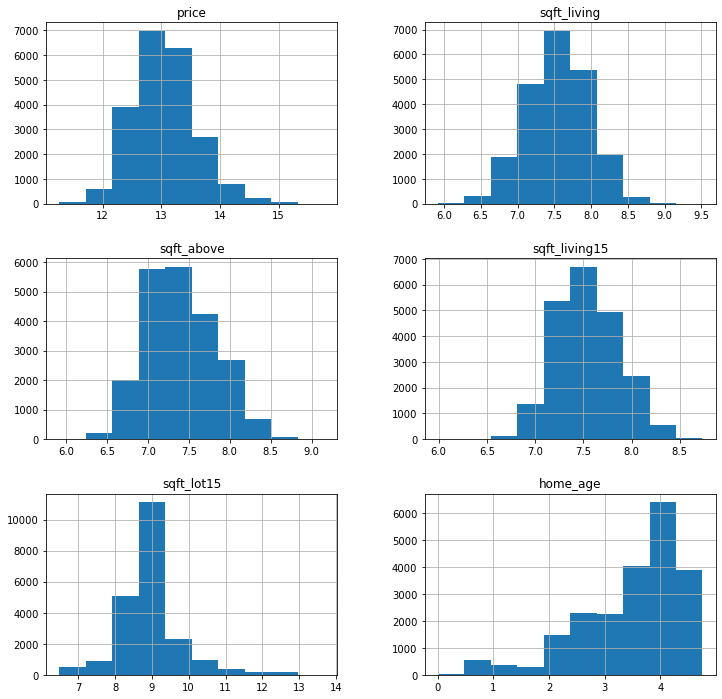

In [70]:
normalized[cont_columns].hist(figsize  = [12, 12]);

Let's construct a model using this data. To deal with the floors, bedrooms and bathrooms, we may end up one-hot encoding it, but let's see how the model performs with the continuous data normalized.

In [71]:
X_train_norm = normalized.drop(columns='price')
y_train_norm = normalized['price']
norm_model = LinearRegression()
norm_val = dp.cross_val(norm_model, X_train_norm, y_train_norm, splits=5, test_size=0.25, random_state=0)

Train score:      0.8499382615681428
Validation score: 0.8495461282176198


This is a decent improvement as it improves the validation score by about 6% to 85% from the unnormalized data. Let's check the linearity, normality and homoscedasticity of the new data to look for anamolies.

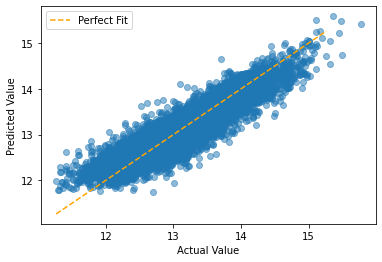

In [72]:
norm_model.fit(X_train_norm, y_train_norm)
viz.linearity_graph(norm_model, X_train_norm, y_train_norm)

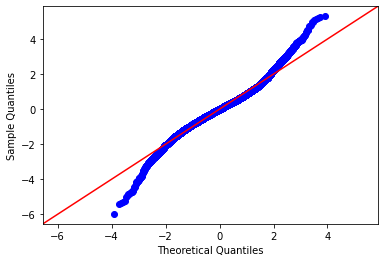

In [73]:
viz.normality_graph(norm_model, X_train_norm, y_train_norm)

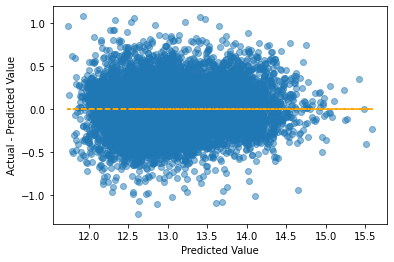

In [74]:
viz.homoscedasticity_graph(norm_model, X_train_norm, y_train_norm)

There is still a issue with the normality of the data. If there is an issue with the linearity or homoscedasticity, it is not apparent in the vizualizations. Let's create a model using statsmodel.api to see how an OLS model performs according to some more tests.

In [75]:
sm.OLS(y_train_norm, sm.add_constant(X_train_norm)).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.850
Method:                 Least Squares   F-statistic:                     2000.
Date:                Thu, 30 Dec 2021   Prob (F-statistic):               0.00
Time:                        14:01:11   Log-Likelihood:                 3785.7
No. Observations:               21583   AIC:                            -7447.
Df Residuals:                   21521   BIC:                            -6953.
Df Model:                          61                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               6.8651      0.079     87.147      0.000       6.711       7.020
sqft_living         0.2462      0.014     17.434      0.000       0.219       0.274
sqft_above          0.2275      0.014     16.351      0.000       0.200       0.255
sqft_living15       0.2197      0.007     29.679      0.000       0.205       0.234
sqft_lot15          0.0163      0.003      5.495      0.000       0.010       0.022
home_age           -0.0038      0.002     -1.585      0.113      -0.008       0.001
bedrooms           -0.0159      0.002     -7.913      0.000      -0.020      -0.012
bathrooms           0.0273      0.003      8.311      0.000       0.021       0.034
sqft_lot         5.181e-07   4.25e-08     12.199      0.000    4.35e-07    6.01e-07
floors             -0.0451      0.004    -10.691      0.000      -0.053      -0.037
waterfront          0.6556      0.017     37.608      0.000       0.621       0.690
yr_ren_miss         0.0045      0.004      1.234      0.217      -0.003       0.012
new_ren             0.1530      0.018      8.587      0.000       0.118       0.188
old_ren             0.1130      0.009     12.908      0.000       0.096       0.130
waterfront_miss    -0.0007      0.004     -0.163      0.871      -0.009       0.008
grade_10            0.4104      0.041     10.013      0.000       0.330       0.491
grade_11            0.5420      0.042     12.869      0.000       0.459       0.625
grade_12            0.6765      0.047     14.506      0.000       0.585       0.768
grade_5            -0.0241      0.041     -0.581      0.561      -0.105       0.057
grade_6             0.0255      0.040      0.642      0.521      -0.052       0.103
grade_7             0.0917      0.040      2.306      0.021       0.014       0.170
grade_8             0.1800      0.040      4.500      0.000       0.102       0.258
grade_9             0.3072      0.040      7.595      0.000       0.228       0.386
cond_Average        0.2179      0.038      5.708      0.000       0.143       0.293
cond_Fair           0.1128      0.041      2.747      0.006       0.032       0.193
cond_Good           0.2788      0.038      7.299      0.000       0.204       0.354
cond_Very Good      0.3510      0.038      9.133      0.000       0.276       0.426
sqft_base_miss      0.0184      0.010      1.854      0.064      -0.001       0.038
has_basement        0.0372      0.006      6.254      0.000       0.026       0.049
Ballard             0.8621      0.009     91.959      0.000       0.844       0.880
Bellevue            0.7422      0.009     82.600      0.000       0.725       0.760
Black Diamond       0.2266      0.022     10.512      0.000       0.184       0.269
Bothell             0.4221      0.016     26.177      0.000       0.391       0.454
Burlen              0.2533      0.010     25.273      0.000

#### Dropping Low P-Value Columns

The varibles: yr_ren_miss, waterfront_miss, and sqft_base_miss all have p-values over 0.05, this likely means that there is no significant features in common in the missing data that isn't in the other data. The condition score over 30 also indicates there is very strong multicollinearity in the model. This is probably caused by all the dummy variables. Let's run the model again without including the missing columns first and see what happens

In [76]:
drop_missing = normalized.drop(columns=['yr_ren_miss', 'waterfront_miss', 'sqft_base_miss'])

In [77]:
X_train_drop = drop_missing.drop(columns=['price'])
y_train_drop = drop_missing['price']
d_missing_model = LinearRegression()
d_missing_val = dp.cross_val(d_missing_model, X_train_drop, y_train_drop, splits=10, test_size=0.25, random_state=0)

Train score:      0.850595201804067
Validation score: 0.8473470513948296


In [78]:
sm.OLS(y_train_drop, sm.add_constant(X_train_drop)).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.850
Method:                 Least Squares   F-statistic:                     2103.
Date:                Thu, 30 Dec 2021   Prob (F-statistic):               0.00
Time:                        14:01:14   Log-Likelihood:                 3783.2
No. Observations:               21583   AIC:                            -7448.
Df Residuals:                   21524   BIC:                            -6978.
Df Model:                          58                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              6.8682      0.079     87.200      0.000       6.714       7.023
sqft_living        0.2508      0.014     18.037      0.000       0.224       0.278
sqft_above         0.2227      0.014     16.292      0.000       0.196       0.250
sqft_living15      0.2196      0.007     29.669      0.000       0.205       0.234
sqft_lot15         0.0163      0.003      5.481      0.000       0.010       0.022
home_age          -0.0038      0.002     -1.572      0.116      -0.008       0.001
bedrooms          -0.0159      0.002     -7.917      0.000      -0.020      -0.012
bathrooms          0.0275      0.003      8.351      0.000       0.021       0.034
sqft_lot        5.185e-07   4.25e-08     12.209      0.000    4.35e-07    6.02e-07
floors            -0.0451      0.004    -10.702      0.000      -0.053      -0.037
waterfront         0.6561      0.017     37.650      0.000       0.622       0.690
new_ren            0.1520      0.018      8.540      0.000       0.117       0.187
old_ren            0.1122      0.009     12.867      0.000       0.095       0.129
grade_10           0.4105      0.041     10.017      0.000       0.330       0.491
grade_11           0.5422      0.042     12.876      0.000       0.460       0.625
grade_12           0.6764      0.047     14.505      0.000       0.585       0.768
grade_5           -0.0241      0.041     -0.582      0.560      -0.105       0.057
grade_6            0.0252      0.040      0.635      0.525      -0.053       0.103
grade_7            0.0915      0.040      2.304      0.021       0.014       0.169
grade_8            0.1801      0.040      4.501      0.000       0.102       0.258
grade_9            0.3072      0.040      7.596      0.000       0.228       0.386
cond_Average       0.2178      0.038      5.706      0.000       0.143       0.293
cond_Fair          0.1128      0.041      2.746      0.006       0.032       0.193
cond_Good          0.2787      0.038      7.297      0.000       0.204       0.354
cond_Very Good     0.3507      0.038      9.125      0.000       0.275       0.426
has_basement       0.0346      0.006      5.984      0.000       0.023       0.046
Ballard            0.8624      0.009     91.988      0.000       0.844       0.881
Bellevue           0.7421      0.009     82.585      0.000       0.724       0.760
Black Diamond      0.2267      0.022     10.514      0.000       0.184       0.269
Bothell            0.4221      0.016     26.178      0.000       0.391       0.454
Burlen             0.2535      0.010     25.302      0.000       0.234       0.273
Capital Hill       1.0184      0.013     76.241      0.000       0.992       1.045
Carnation          0.2982      0.020     15.056      0.000       0.259       0.337
Des Moines         0.0968      0.014      6.930      0.000       0.069       0.124
Downtown    

Eliminating the missing value columns didn't significatly change the performance of the model either way, so we will leave them out, since it make the model slightly simpler. However, there is still a lot of collinearity in the model, since we are using the model for purposes of prediction, this is not a decisive issue against using the model.

#### One-Hot Encoding Labeled Data

#### *Encoding Bathroom Data*

Let's start with the bathroom data. As we can see there are alot of different combinations including half bathrooms and three quarter bathrooms. There are also a lot of fairly extreme outliers that won't be relevant to our client's business problems. 

In [79]:
drop_missing.bathrooms.value_counts()

2.50    5376
1.00    3851
1.75    3048
2.25    2047
2.00    1930
1.50    1445
2.75    1185
3.00     753
3.50     731
3.25     588
3.75     154
4.00     135
4.50     100
4.25      78
0.75      70
4.75      22
5.00      20
5.25      13
1.25       9
5.50       8
6.00       6
0.50       4
5.75       3
6.50       2
6.75       2
8.00       1
7.50       1
6.25       1
Name: bathrooms, dtype: int64

To slightly reduce the model complexity and reducde the number of categories we need, we will drop homes with greater than 5 bathrooms or less than 1 bathroom, which should be acceptable given the small number of homes with those features.

In [80]:
encoded_df = drop_missing.drop(drop_missing[drop_missing.bathrooms > 5].index)
encoded_df = encoded_df.drop(encoded_df[encoded_df.bathrooms < 1].index)
encoded_df['bathrooms'].value_counts()

2.50    5376
1.00    3851
1.75    3048
2.25    2047
2.00    1930
1.50    1445
2.75    1185
3.00     753
3.50     731
3.25     588
3.75     154
4.00     135
4.50     100
4.25      78
4.75      22
5.00      20
1.25       9
Name: bathrooms, dtype: int64

In [81]:
encoded_df['bathrooms'] = encoded_df['bathrooms'].astype(str)
cats_bathrooms, encode_bathrooms = dp.one_hot_encode(encoded_df, 'bathrooms', prefix='bathrooms_')
encoded_df[cats_bathrooms] = encode_bathrooms

In [83]:
#One Column Dropped to avoid dummy variable trap
encoded_df = encoded_df.drop(columns=['bathrooms', 'bathrooms_1.0'])
encoded_df.columns

Index(['price', 'sqft_living', 'sqft_above', 'sqft_living15', 'sqft_lot15',
       'home_age', 'bedrooms', 'sqft_lot', 'floors', 'waterfront', 'new_ren',
       'old_ren', 'grade_10', 'grade_11', 'grade_12', 'grade_5', 'grade_6',
       'grade_7', 'grade_8', 'grade_9', 'cond_Average', 'cond_Fair',
       'cond_Good', 'cond_Very Good', 'has_basement', 'Ballard', 'Bellevue',
       'Black Diamond', 'Bothell', 'Burlen', 'Capital Hill', 'Carnation',
       'Des Moines', 'Downtown', 'Duvail', 'Federal Way', 'Issaquah',
       'Kenmore', 'Kent', 'Kirkland', 'Maple Valley', 'Medina',
       'Mercer Island', 'N Seattle', 'NE King County', 'NE Seattle',
       'North Bend', 'Queen Anne', 'Redmond', 'Renton', 'SE King County',
       'SE Seattle', 'Sammamish', 'Seatac', 'Snoqualmie', 'Vashon Island',
       'West Seattle', 'Woodinville', 'bathrooms_1.25', 'bathrooms_1.5',
       'bathrooms_1.75', 'bathrooms_2.0', 'bathrooms_2.25', 'bathrooms_2.5',
       'bathrooms_2.75', 'bathrooms_3.0', 'bathr

#### *Encoding Floors Data*

Although there are some infrequent floor numbers like 3.5, we will keep all this data, since 6 categories isn't ridiculous.

In [84]:
encoded_df.floors.value_counts()

1.0    10601
2.0     8191
1.5     1905
3.0      610
2.5      158
3.5        7
Name: floors, dtype: int64

In [86]:
encoded_df['floors'] = encoded_df['floors'].astype(str)
cats_floors, encode_floors = dp.one_hot_encode(encoded_df, 'floors', prefix='floors_')
encoded_df[cats_floors] = encode_floors

In [88]:
#One Column Dropped to avoid dummy variable trap
encoded_df = encoded_df.drop(columns=['floors', 'floors_1.0'])
encoded_df.columns

Index(['price', 'sqft_living', 'sqft_above', 'sqft_living15', 'sqft_lot15',
       'home_age', 'bedrooms', 'sqft_lot', 'waterfront', 'new_ren', 'old_ren',
       'grade_10', 'grade_11', 'grade_12', 'grade_5', 'grade_6', 'grade_7',
       'grade_8', 'grade_9', 'cond_Average', 'cond_Fair', 'cond_Good',
       'cond_Very Good', 'has_basement', 'Ballard', 'Bellevue',
       'Black Diamond', 'Bothell', 'Burlen', 'Capital Hill', 'Carnation',
       'Des Moines', 'Downtown', 'Duvail', 'Federal Way', 'Issaquah',
       'Kenmore', 'Kent', 'Kirkland', 'Maple Valley', 'Medina',
       'Mercer Island', 'N Seattle', 'NE King County', 'NE Seattle',
       'North Bend', 'Queen Anne', 'Redmond', 'Renton', 'SE King County',
       'SE Seattle', 'Sammamish', 'Seatac', 'Snoqualmie', 'Vashon Island',
       'West Seattle', 'Woodinville', 'bathrooms_1.25', 'bathrooms_1.5',
       'bathrooms_1.75', 'bathrooms_2.0', 'bathrooms_2.25', 'bathrooms_2.5',
       'bathrooms_2.75', 'bathrooms_3.0', 'bathrooms_3.25'

#### *Encoding Bedroom Data*

As we noted in the initial data exploration thre are a number of outlier in the number of bedrooms.

In [89]:
encoded_df.bedrooms.value_counts()

3     9807
4     6865
2     2732
5     1581
6      264
1      168
7       34
8       12
9        5
10       2
11       1
33       1
Name: bedrooms, dtype: int64

Again to simplify a bit we will drop any homes with 10 or more bedrooms before encoding.

In [90]:
encoded_df = encoded_df.drop(encoded_df[encoded_df.bedrooms >= 10].index)
encoded_df['bedrooms'].value_counts()

3    9807
4    6865
2    2732
5    1581
6     264
1     168
7      34
8      12
9       5
Name: bedrooms, dtype: int64

In [91]:
encoded_df['bedrooms'] = encoded_df['bedrooms'].astype(str)
cats_bedrooms, encode_bedrooms = dp.one_hot_encode(encoded_df, 'bedrooms', prefix='bedrooms_')
encoded_df[cats_bedrooms] = encode_bedrooms

In [92]:
#One Column Dropped to avoid dummy variable trap
encoded_df = encoded_df.drop(columns=['bedrooms', 'bedrooms_1'])
encoded_df.columns

Index(['price', 'sqft_living', 'sqft_above', 'sqft_living15', 'sqft_lot15',
       'home_age', 'sqft_lot', 'waterfront', 'new_ren', 'old_ren', 'grade_10',
       'grade_11', 'grade_12', 'grade_5', 'grade_6', 'grade_7', 'grade_8',
       'grade_9', 'cond_Average', 'cond_Fair', 'cond_Good', 'cond_Very Good',
       'has_basement', 'Ballard', 'Bellevue', 'Black Diamond', 'Bothell',
       'Burlen', 'Capital Hill', 'Carnation', 'Des Moines', 'Downtown',
       'Duvail', 'Federal Way', 'Issaquah', 'Kenmore', 'Kent', 'Kirkland',
       'Maple Valley', 'Medina', 'Mercer Island', 'N Seattle',
       'NE King County', 'NE Seattle', 'North Bend', 'Queen Anne', 'Redmond',
       'Renton', 'SE King County', 'SE Seattle', 'Sammamish', 'Seatac',
       'Snoqualmie', 'Vashon Island', 'West Seattle', 'Woodinville',
       'bathrooms_1.25', 'bathrooms_1.5', 'bathrooms_1.75', 'bathrooms_2.0',
       'bathrooms_2.25', 'bathrooms_2.5', 'bathrooms_2.75', 'bathrooms_3.0',
       'bathrooms_3.25', 'bathrooms

#### One-Hot Model

Let's create a model with the newly recategorized bathroom, floor and bedroom data and see how it performs.

In [93]:
X_train_one_hot = encoded_df.drop(columns=['price'])
y_train_one_hot = encoded_df['price']
one_hot_model = LinearRegression()
one_hot_val = dp.cross_val(one_hot_model, X_train_one_hot, y_train_one_hot, splits=10, test_size=0.25, random_state=0)

Train score:      0.8499016415215962
Validation score: 0.8498318600697635


In [94]:
sm.OLS(y_train_one_hot, sm.add_constant(X_train_one_hot)).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.850
Method:                 Least Squares   F-statistic:                     1444.
Date:                Thu, 30 Dec 2021   Prob (F-statistic):               0.00
Time:                        14:03:46   Log-Likelihood:                 3938.8
No. Observations:               21468   AIC:                            -7708.
Df Residuals:                   21383   BIC:                            -7030.
Df Model:                          84                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              6.7423      0.090     75.191      0.000       6.567       6.918
sqft_living        0.2775      0.014     19.506      0.000       0.250       0.305
sqft_above         0.1946      0.014     13.808      0.000       0.167       0.222
sqft_living15      0.2196      0.007     29.408      0.000       0.205       0.234
sqft_lot15         0.0153      0.003      5.164      0.000       0.010       0.021
home_age          -0.0062      0.002     -2.506      0.012      -0.011      -0.001
sqft_lot        5.182e-07   4.29e-08     12.069      0.000    4.34e-07    6.02e-07
waterfront         0.6545      0.018     36.758      0.000       0.620       0.689
new_ren            0.1508      0.018      8.524      0.000       0.116       0.185
old_ren            0.1116      0.009     12.765      0.000       0.094       0.129
grade_10           0.5510      0.056      9.915      0.000       0.442       0.660
grade_11           0.6684      0.056     11.839      0.000       0.558       0.779
grade_12           0.7986      0.061     13.186      0.000       0.680       0.917
grade_5            0.1084      0.056      1.940      0.052      -0.001       0.218
grade_6            0.1655      0.055      3.025      0.002       0.058       0.273
grade_7            0.2430      0.055      4.438      0.000       0.136       0.350
grade_8            0.3352      0.055      6.103      0.000       0.228       0.443
grade_9            0.4577      0.055      8.291      0.000       0.350       0.566
cond_Average       0.2187      0.039      5.671      0.000       0.143       0.294
cond_Fair          0.1116      0.041      2.692      0.007       0.030       0.193
cond_Good          0.2789      0.039      7.225      0.000       0.203       0.355
cond_Very Good     0.3496      0.039      9.005      0.000       0.274       0.426
has_basement       0.0279      0.006      4.762      0.000       0.016       0.039
Ballard            0.8538      0.010     89.460      0.000       0.835       0.873
Bellevue           0.7434      0.009     82.746      0.000       0.726       0.761
Black Diamond      0.2190      0.022     10.182      0.000       0.177       0.261
Bothell            0.4231      0.016     26.402      0.000       0.392       0.455
Burlen             0.2500      0.010     24.936      0.000       0.230       0.270
Capital Hill       1.0057      0.013     75.056      0.000       0.979       1.032
Carnation          0.2925      0.020     14.570      0.000       0.253       0.332
Des Moines         0.0957      0.014      6.873      0.000       0.068       0.123
Downtown           0.7560      0.011     67.087      0.000       0.734       0.778
Duvail             0.3034      0.016     18.644      0.000       0.271       0.335
Federal Way       -0.0140      0.010     -1.405      0.160      -0.033       0.006
Issaquah    

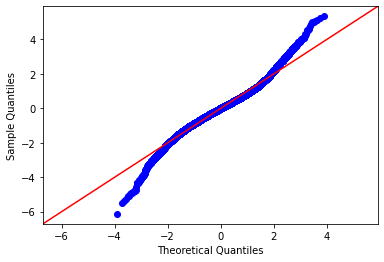

In [121]:
one_hot_model.fit(X_train_one_hot, y_train_one_hot)
viz.normality_graph(one_hot_model, X_train_one_hot, y_train_one_hot)

As we can see, the model didn't perform any better and the floor and bedroom data all have very high p-values when treated as categories. This might reflect the loss of the oridinal ranking information that existed in the label encoded data.

Since the model with floors, bathrooms and bedrooms one-hot encoded is more complex, with little actual gain in performance, we will use the previous model as the final model.

In [95]:
final_model = LinearRegression()
X_train_final = drop_missing.drop(columns='price')
y_train_final = drop_missing['price']
final_model.fit(X_train_final, y_train_final)

LinearRegression()

## Evaluating the Final Model

In [96]:
final_model.coef_

array([ 2.50845735e-01,  2.22745745e-01,  2.19648086e-01,  1.62562620e-02,
       -3.76383426e-03, -1.59374983e-02,  2.74747857e-02,  5.18480329e-07,
       -4.51474275e-02,  6.56083889e-01,  1.51996927e-01,  1.12240466e-01,
        4.10484463e-01,  5.42197977e-01,  6.76388651e-01, -2.41151287e-02,
        2.52420772e-02,  9.15418409e-02,  1.80054178e-01,  3.07175693e-01,
        2.17795784e-01,  1.12750267e-01,  2.78738594e-01,  3.50653919e-01,
        3.45613440e-02,  8.62356841e-01,  7.42071038e-01,  2.26661943e-01,
        4.22148907e-01,  2.53544491e-01,  1.01838711e+00,  2.98232333e-01,
        9.68410727e-02,  7.66973500e-01,  3.04215995e-01, -1.51845541e-02,
        5.22492825e-01,  4.08098255e-01,  4.40813796e-02,  6.42785659e-01,
        1.47782291e-01,  1.23568280e+00,  8.52638379e-01,  5.21608518e-01,
        4.25173491e-01,  8.77214391e-01,  3.30609401e-01,  9.42609761e-01,
        5.51036228e-01,  2.37775655e-01,  6.06357304e-02,  3.95014362e-01,
        5.17638202e-01,  

## Interpreting the Model

So we have our final model, unfortunately since we log normalized the price and some other data, the coeffients are not as directly interpretable since they are not in the units or scale of the original values.

In [97]:
coef = pd.DataFrame(np.zeros((1, len(X_train_drop.columns))))
coef.columns = X_train_drop.columns
coef[X_train_drop.columns] = final_model.coef_
coef.transpose().head()

,0
sqft_living,0.250846
sqft_above,0.222746
sqft_living15,0.219648
sqft_lot15,0.016256
home_age,-0.003764


To make the coefficients interpretable we will transform them.

In [98]:
unnormalized_var = set(coef.columns) - set(cont_columns)
normalized_var = set(cont_columns) - {'price'}

In [99]:
for column in unnormalized_var:
    coef[column] = (coef[column].map(np.expm1))*100

For all the variables that we didn't normalize, these coefficients represent percent increases per 1 unit increase in the case of floors, bathrooms and bedrooms.

So, for example, according to the model, adding floors or bedrooms will on average lower the home price by a few precent, but adding a full bathroom will increase the value by around 3%.

In [100]:
coef[['floors', 'bathrooms', 'bedrooms']].transpose()

,0
floors,-4.414345
bathrooms,2.785570
bedrooms,-1.581117


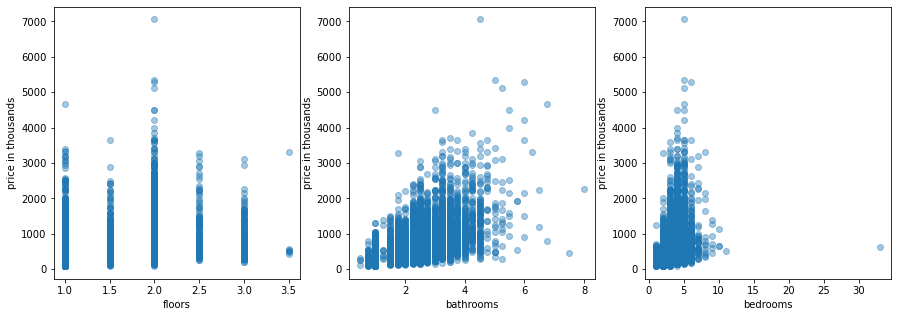

In [101]:
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(15, 5))
cols = ['floors', 'bathrooms', 'bedrooms']
for index, col in enumerate(cols):
    ax = axes[index]
    ax.scatter(X_train_final[col], np.expm1(y_train_final)/1000, alpha = 0.4)
    ax.set_xlabel(col)
    ax.set_ylabel("price in thousands")

#### Visualizing Location Effects

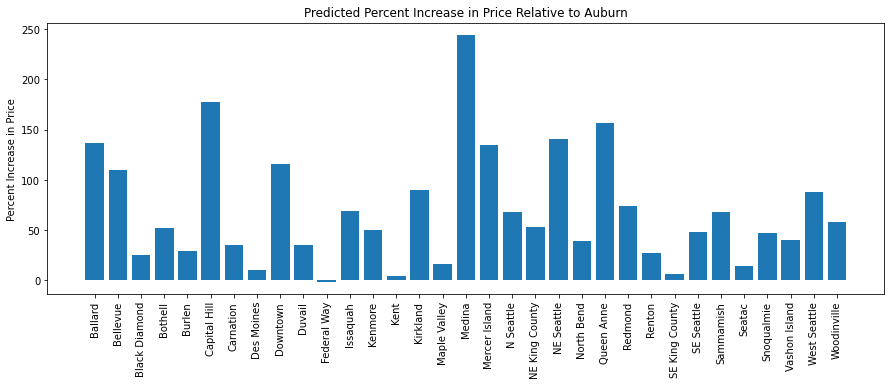

In [111]:
location_coef = []
for location in locations:
    location_coef.append(float(coef[location]))
fig, ax = plt.subplots(figsize=(15, 5))
ax = plt.bar(locations, location_coef)
plt.xticks(rotation = 90)
plt.ylabel("Percent Increase in Price")
plt.title("Predicted Percent Increase in Price Relative to Auburn");

#### Visualizing Grade Effects

In [117]:
cats_grade.remove('grade_4')

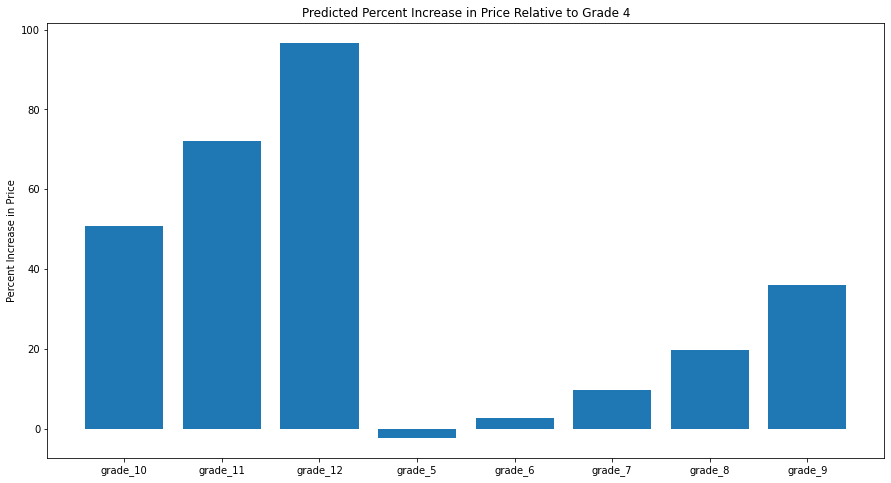

In [132]:
grade_coef = [] 
for cat in cats_grade:
    grade_coef.append(float(coef[cat]))
fig, ax = plt.subplots(figsize=(15, 8))
ax = plt.bar(cats_grade, grade_coef)
plt.ylabel("Percent Increase in Price")
plt.title("Predicted Percent Increase in Price Relative to Grade 4");

In [123]:
cats_cond.remove('cond_Poor')

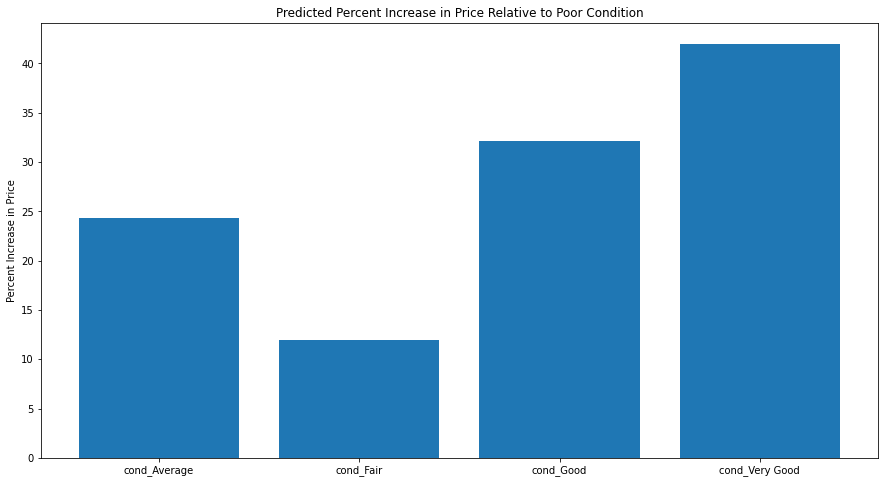

In [133]:
cond_coef = [] 
for cat in cats_cond:
    cond_coef.append(float(coef[cat]))
fig, ax = plt.subplots(figsize=(15, 8))
ax = plt.bar(cats_cond, cond_coef)

plt.ylabel("Percent Increase in Price")
plt.title("Predicted Percent Increase in Price Relative to Poor Condition");

In [130]:
cats_yr_ren.remove('not_ren')

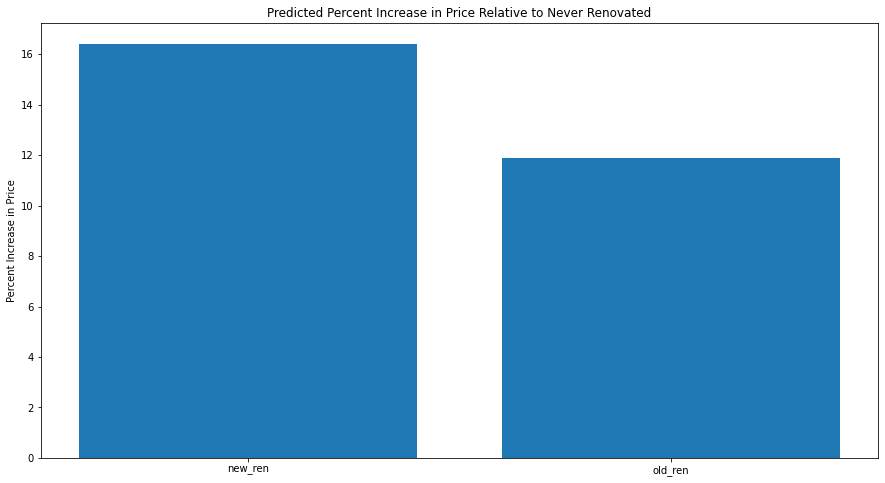

In [134]:
ren_coef = [] 
for cat in cats_yr_ren:
    ren_coef.append(float(coef[cat]))
fig, ax = plt.subplots(figsize=(15, 8))
ax = plt.bar(cats_yr_ren, ren_coef)

plt.ylabel("Percent Increase in Price")
plt.title("Predicted Percent Increase in Price Relative to Never Renovated");

But we can make a function that will give us rescaled difference between the predictions about the median homes with different features to get a feel for the data. For example our model predicts that the median 2 bathroom home is valued $51,318 more than the median 1 bathroom home.

In [ ]:
round(dp.predict_difference(final_model, X_train, 'bathrooms', 1, 2, scaler_cond, nonbool_columns), ndigits=2)

We can also construct some visualizations to see these predictions and the data they are based on more clearly for all the variables.

In [ ]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(12, 8))
fig.set_tight_layout(True)
cols = ['bedrooms','bathrooms', 'sqft_living', 'floors', 'grade', 'sqft_above']

for index, col in enumerate(cols):
    predict_df = dp.predict_median_effect(X_train, col, nonbool_columns, scaler_cond, final_model)
    ax = axes[index//3][index%3]
    ax.scatter(predict_df[col], predict_df['price']/1000, alpha = 0.4)
    clean_med = clean.groupby(col).median().reset_index()
    ax.scatter(clean_med[col], clean_med['price']/1000, c='orange', alpha = 0.4)
    ax.set_xlabel(col)
    ax.set_ylabel("price")
    ax.legend(labels=['Prediction', 'Data'])

We can see the error is quite large in some areas, to get a better grip on what that means in practice, let's calculate the unstandardized mean squared error of the model.

In [ ]:
X = cond_rated.drop(columns='price')
y = cond_rated['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
dp.unstandard_mean_sq_error(final_model, X_train, y_train, X_test, y_test, scaler=scaler_cond)

This is obviously a very large real world error, but we can see from the visualizations that much of this error is coming from the larger more expensive homes, and that the model is being too conservative about their prices. It's predictions are much more accurate for the more median home.

To end we created a function that can be used to get predictions from the model for input values. For example, we can use it to predict that a 3 bedroom home with 2 bathrooms with 1 floor of 1200 sqft and a 500 sqft basement, that is in good condition and has an average grade score, and was renovated, but not recently, would have a predicted price of $544,664

In [ ]:
dp.give_prediction(final_model, X_train.columns, scaler_cond, nonbool_columns)